In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import numpy as np
import calmap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [3]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [4]:
new_df = pd.read_feather('./twitter_new_analysis.ftr')
old_df = pd.read_feather('./twitter_old_analysis.ftr')
new_df.shape
old_df.shape

(33966, 4)

In [5]:
new_df["negativeSentimentScore"] = new_df["sentimentScore"].map(lambda x: x[0])
new_df["neutralSentimentScore"] = new_df["sentimentScore"].map(lambda x: x[1])
new_df["positiveSentimentScore"] = new_df["sentimentScore"].map(lambda x: x[2])

old_df["negativeSentimentScore"] = old_df["sentimentScore"].map(lambda x: x[0])
old_df["neutralSentimentScore"] = old_df["sentimentScore"].map(lambda x: x[1])
old_df["positiveSentimentScore"] = old_df["sentimentScore"].map(lambda x: x[2])

In [6]:
polar_tweets_new_df = new_df[new_df["neutralSentimentScore"] <= 0.33]
nonpolar_tweets_new_df = new_df[new_df["neutralSentimentScore"] > 0.33]
print(polar_tweets_new_df.shape[0])
print(nonpolar_tweets_new_df.shape[0])
print(polar_tweets_new_df.shape[0]/(polar_tweets_new_df.shape[0] + nonpolar_tweets_new_df.shape[0]))

543409
1100602
0.33053854262532306


In [7]:
def getYearMonth(s):
    return f"{s.year}-{s.month}"

new_df['tweet_ts'] = pd.to_datetime(new_df['tweet_ts'], format='%d-%m-%Y')
new_df['tweet_month_year'] = new_df['tweet_ts'].apply(lambda x: getYearMonth(x))
new_df['tweet_month_year'] = pd.to_datetime(new_df['tweet_month_year'],format='%Y-%m')

old_df['tweet_ts'] = pd.to_datetime(old_df['tweet_ts'], format='%d-%m-%Y')
old_df['tweet_month_year'] = old_df['tweet_ts'].apply(lambda x: getYearMonth(x))
old_df['tweet_month_year'] = pd.to_datetime(old_df['tweet_month_year'], format='%Y-%m')


In [8]:
new_df_monthly = new_df.groupby("tweet_month_year").mean(numeric_only=False).reset_index()
old_df_monthly = old_df.groupby("tweet_month_year").mean(numeric_only=False).reset_index()

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/1168138830.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  new_df_monthly = new_df.groupby("tweet_month_year").mean(numeric_only=False).reset_index()
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/1168138830.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  old_df_monthly = old_df.groupby("tweet_month_year").mean(numeric_only=False).reset_index()


In [9]:
print("New DS limits: ", new_df.agg({ 'tweet_ts' : [np.min, np.max]}))
print("Old DS limits: ", old_df.agg({ 'tweet_ts' : [np.min, np.max]}))

New DS limits:         tweet_ts
amin 2021-12-29
amax 2023-04-13
Old DS limits:         tweet_ts
amin 2015-04-27
amax 2018-02-22


1. Count the number of tweets with various hashtags and present the most popular hashtags
2. Global minimal and maximal sentiment
3. What hashtags tend to be related to more positive, and what to more negative tweets?
4. Average negative sentiment for each year; average positive sentiment for each year


### Analyze hashtags

In [10]:
def getTopHashtags(datafr):
    hashtags = datafr["hashtags"].to_list()
    hashtags = [item for sublist in hashtags for item in sublist]

    hashtags = pd.Series(hashtags)
    unique_hashtags = hashtags.value_counts()
    return unique_hashtags.head(15)

def getHashtagList(datafr):
    hashtags = datafr["hashtags"].to_list()
    hashtags = [item for sublist in hashtags for item in sublist]

    hashtags = pd.Series(hashtags)
    return hashtags.unique()

In [11]:
def plotHashtagBarChart(datafr):
    fig = plt.figure(figsize = (10, 5))
    fig.patch.set_facecolor('white')

    dfLimits = datafr.agg({ 'tweet_ts' : [np.min, np.max]})
    print("New DS limits: ", dfLimits["tweet_ts"]["amin"])

    fromD = dfLimits["tweet_ts"]["amin"].strftime("%m/%d/%Y")
    toD = dfLimits["tweet_ts"]["amax"].strftime("%m/%d/%Y")

    hashtagCounts = getTopHashtags(datafr)

    plt_hashtags = list(hashtagCounts.keys())
    plt_counts = list(hashtagCounts)
    print(plt_hashtags)

    ax=plt.axes()
    ax.patch.set_facecolor('white')
    ax.spines[['top','left','bottom']].set_visible(False)
    # Make the left spine thicker
    ax.spines['right'].set_linewidth(1.1)
    plt.grid(which="major", axis='x', color='#DAD8D7', alpha=0.25, zorder=1)
    plt.grid(which="major", axis='y', color='#DAD8D7', alpha=0.25, zorder=1)

    # creating the bar plot
    plt.barh( plt_hashtags, plt_counts,  color ='cornflowerblue')
    
    plt.xlabel("No. of related tweets")
    plt.title(f"Hashtag popularity for {fromD} - {toD}", fontsize = 16)
    
    plt.gca().invert_yaxis()
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

    plt.show()

In [12]:
df_2015 = old_df[(old_df['tweet_ts'] <= '2015-12-31')]
df_2016 = old_df[(old_df['tweet_ts'] >= '2016-01-01') & (old_df['tweet_ts'] <= '2016-12-31')]
df_2017 = old_df[(old_df['tweet_ts'] >= '2017-01-01') & (old_df['tweet_ts'] <= '2017-12-31')]
df_2018 = old_df[(old_df['tweet_ts'] >= '2018-01-01') & (old_df['tweet_ts'] <= '2018-12-31')]

df_2022 = new_df[(new_df['tweet_ts'] >= '2022-01-01') & (new_df['tweet_ts'] <= '2022-12-31')]
df_2023 = new_df[(new_df['tweet_ts'] >= '2023-01-01') & (new_df['tweet_ts'] <= '2023-12-31')]

In [13]:
df_2022[
    (df_2022['tweet_ts'] >= '2022-07-19') & (df_2022['tweet_ts'] <= '2022-07-20') & (df_2022["negativeSentimentScore"] > 0.3)\
    ]\
    .sort_values("negativeSentimentScore", ascending=False)\
    [['tweet', 'sentimentScore', 'tweet_ts']]\
    .head(30)


,tweet,sentimentScore,tweet_ts
2147872,fuck fuck #executiveorder #climatechange fucking #farce #joke whole administration. #closetheborder inept fuck! #drillforoil get #fracking finish #wall #keystonepipeline #crime #lawandorder #blackouts #inflation #vote #gop,"[0.9550142, 0.03926868, 0.0057171998]",2022-07-20
504368,"joe biden even declare national emergency. he's worthless #climatechange, actually made things significantly *worse* democrats corrupt #bif bill. unfit proved 18 months.","[0.9527214, 0.041413534, 0.0058650584]",2022-07-20
1951994,damned female reporter bbc news (didnt catch name) banging bloody #climatechange! disgraceful abuse position push propaganda public. #defundthebbc,"[0.951498, 0.043818187, 0.0046838387]",2022-07-19
530153,fuck. this. shit. #covid19 #climatecrisis #neoliberalism #endtimes #latestagecapitalism,"[0.95071226, 0.04366686, 0.0056208493]",2022-07-20
33702,heartbreaking senator walked negotiations something! hes pathetic dino only. #climatecrisis,"[0.9506174, 0.04347404, 0.005908614]",2022-07-20
701178,europe fire america china like yeh fuck continue absolute worst. #europe #climatecrisis #heatwave #heatwave2022,"[0.9496712, 0.04484759, 0.005481289]",2022-07-19
1953156,youre targeting wrong fucking people!! better. #juststopoil #climateemergency #climatecrisis,"[0.9487785, 0.046400916, 0.0048205624]",2022-07-20
1060337,two month anniversary election pm. he's australia's worst labor prime minister ever. backflipped national cabinet secrecy; independent speaker parliament; refuses take #climatecrisis seriously; ignored health advice.,"[0.9485999, 0.04669571, 0.0047044037]",2022-07-20
824075,health care sucks is. also promised could keep doctors price gouged. well lie #climatecrisis,"[0.9481492, 0.046230357, 0.005620454]",2022-07-19
1608050,"london fire right #climatechange fckng tories done nothing address underlying issue. 12 years. country, despair you. wake up.","[0.9477642, 0.047496997, 0.004738859]",2022-07-19


New DS limits:  2015-04-27 00:00:00
['#climate', '#cop21', '#climatechange', '#actonclimate', '#tcot', '#globalwarming', '#thesuperhuman', '#demdebate', '#news', '#auspol', '#science', '#cdnpoli', '#gopdebate', '#pjnet', '#uniteblue']


/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2813215829.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


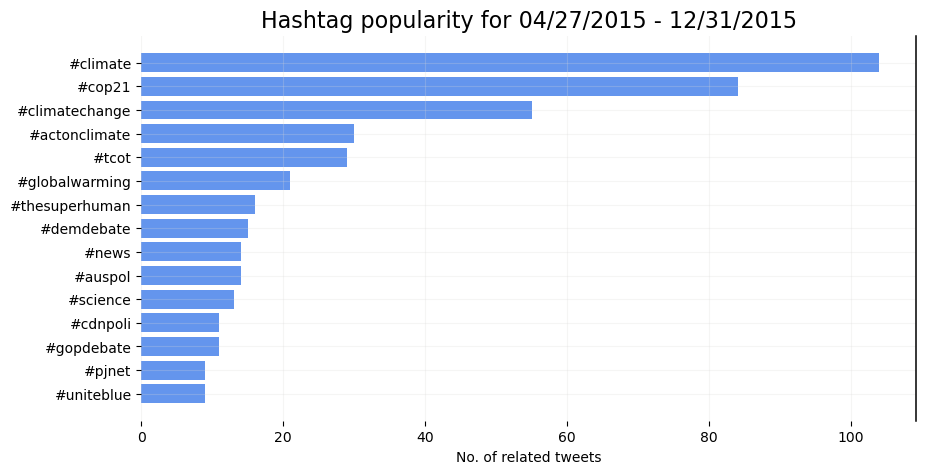

New DS limits:  2016-01-01 00:00:00
['#climate', '#climatechange', '#cop22', '#beforetheflood', '#trump', '#parisagreement', '#auspol', '#globalwarming', '#environment', '#actonclimate', '#news', '#science', '#debatenight', '#tcot', '#climatecounts']


/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2813215829.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


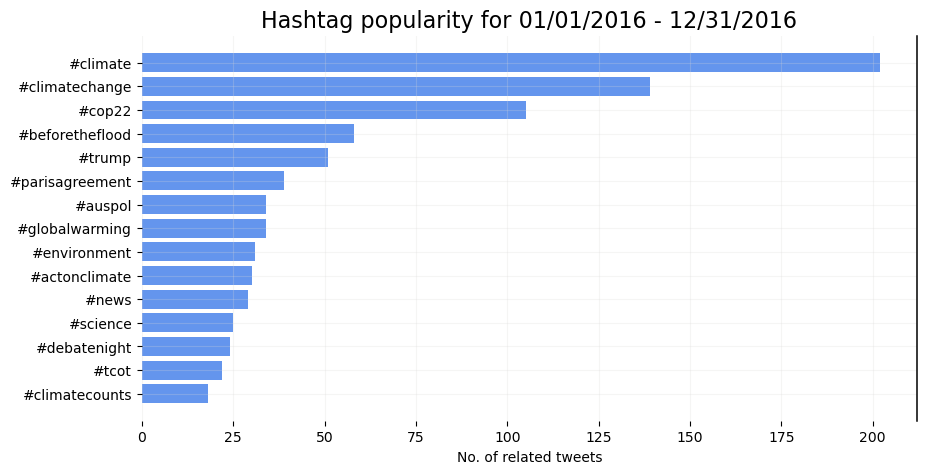

New DS limits:  2017-01-01 00:00:00
['#climate', '#climatechange', '#environment', '#trump', '#parisagreement', '#globalwarming', '#actonclimate', '#science', '#resist', '#auspol', '#news', '#climatemarch', '#maga', '#epa', '#qanda']


/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2813215829.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


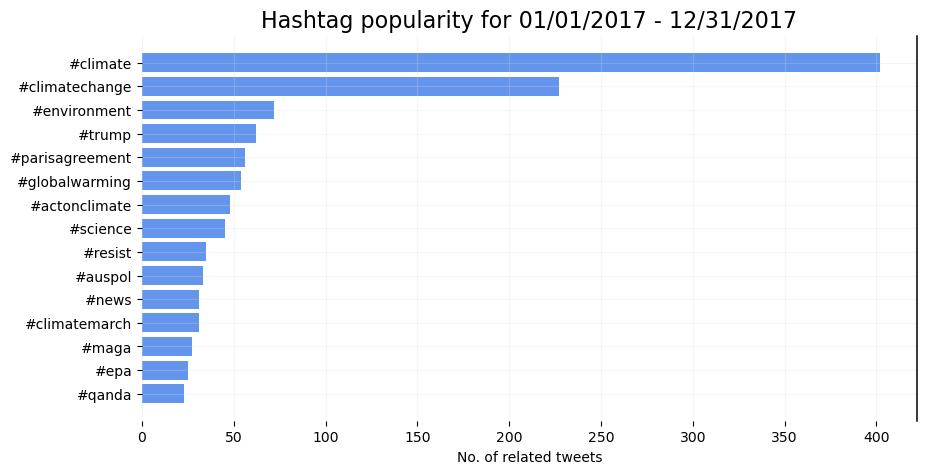

New DS limits:  2018-01-01 00:00:00
['#climatechange', '#climate', '#globalwarming', '#sotu', '#environment', '#trump', '#blockchain', '#news', '#auspol', '#science', '#climateaction', '#wef18', '#actonclimate', '#maga', '#fakenews']


/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2813215829.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


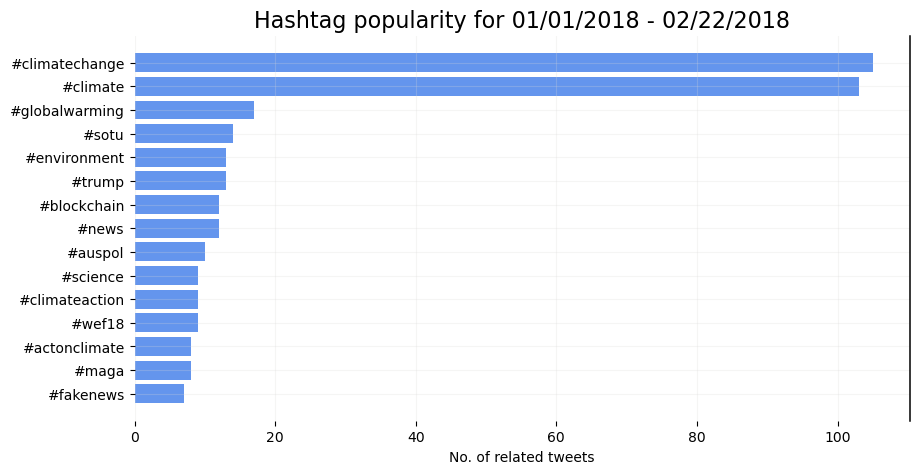

New DS limits:  2022-01-01 00:00:00
['#climatechange', '#climatecrisis', '#climateaction', '#climateemergency', '#climate', '#globalwarming', '#sustainability', '#environment', '#cop27', '#climateactionnow', '#renewableenergy', '#climatejustice', '#nature', '#energy', '#auspol']


/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2813215829.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


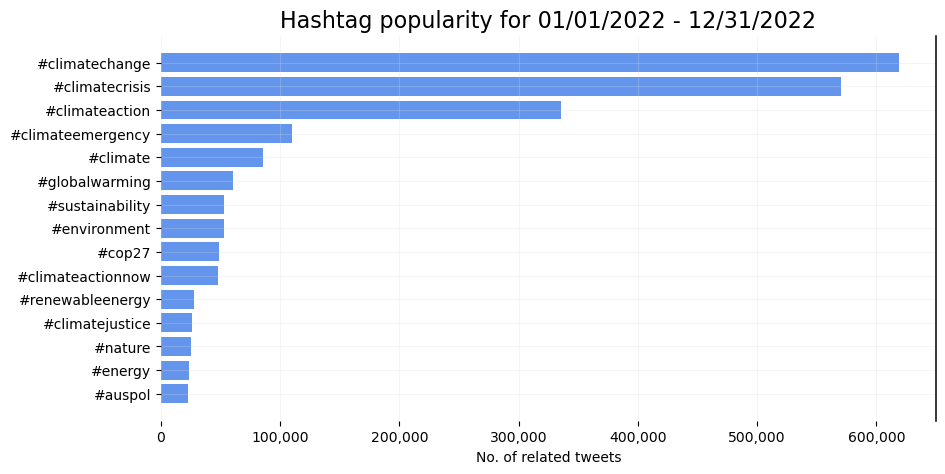

New DS limits:  2023-01-01 00:00:00
['#climatechange', '#climatecrisis', '#climateaction', '#climateemergency', '#climate', '#globalwarming', '#sustainability', '#news', '#climateline', '#environment', '#climatescam', '#renewableenergy', '#netzero', '#energy', '#pollution']


/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2813215829.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


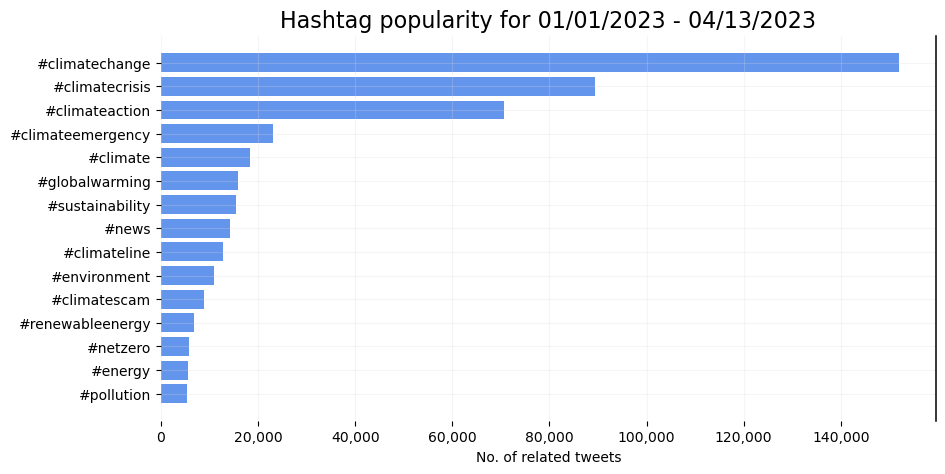

In [14]:

plotHashtagBarChart(df_2015)
plotHashtagBarChart(df_2016)
plotHashtagBarChart(df_2017)
plotHashtagBarChart(df_2018)

plotHashtagBarChart(df_2022)
plotHashtagBarChart(df_2023)

In [15]:
def getTimeseriesSentimentGraph(df):
    fig = plt.figure(figsize = (10, 5))
    fig.patch.set_facecolor('white')

    ax=plt.axes()
    ax.patch.set_facecolor('white')
    ax.spines[['top','left','bottom']].set_visible(False)
    # Make the left spine thicker
    ax.spines['right'].set_linewidth(1.1)
    plt.grid(which="major", axis='x', color='#DAD8D7', alpha=0.25, zorder=1)
    plt.grid(which="major", axis='y', color='#DAD8D7', alpha=0.25, zorder=1)
    
    dfLimits = df.agg({ 'tweet_ts' : [np.min, np.max]})
    print("New DS limits: ", dfLimits["tweet_ts"]["amin"])

    fromD = dfLimits["tweet_ts"]["amin"].strftime("%d/%m/%Y")
    toD = dfLimits["tweet_ts"]["amax"].strftime("%d/%m/%Y")
    plt.title(f"Average monthly sentiment for {fromD} - {toD}")

    sns.lineplot(data=df, x ='tweet_ts', y = 'positiveSentimentScore', legend='full', lw=1.5, label="positive sentiment", color='#36AE7C')
    sns.lineplot(data=df, x ='tweet_ts', y = 'neutralSentimentScore', legend='full', lw=1.5, label="neutral sentiment", color='#6495ed')
    sns.lineplot(data=df, x ='tweet_ts', y = 'negativeSentimentScore', legend='full', lw=1.5, label="negative sentiment", color='#D14D72')

    legend = plt.legend(bbox_to_anchor=(1, 1))
    frame = legend.get_frame()
    frame.set_facecolor('white')

    plt.ylabel('Sentiment score')
    plt.xlabel('')
    plt.show()

In [16]:
def getTimeseriesSentimentBarGraph(df):
    dfLimits = df.agg({ 'tweet_ts' : [np.min, np.max]})
    fromD = dfLimits["tweet_ts"]["amin"].strftime("%d/%m/%Y")
    toD = dfLimits["tweet_ts"]["amax"].strftime("%d/%m/%Y")
    df['date'] = df['tweet_month_year'].dt.strftime("%m-%Y")
    dfForChart = df[["date", "negativeSentimentScore", "neutralSentimentScore", "positiveSentimentScore"]]

    fig = plt.figure(figsize = (10, 5))
    fig.patch.set_facecolor('white')

    chart = dfForChart.plot(
        x="date", kind='bar', stacked=True,
        color=['#D14D72', '#89CFF0', '#36AE7C'],
        title=f"Average monthly sentiment for {fromD} - {toD}",
        figsize=(12,5)
    )
    
    chart.patch.set_facecolor('white')
    # # Make the left spine thicker
    chart.grid(which="major", axis='x', color='#DAD8D7', alpha=0.25, zorder=1)
    chart.grid(which="major", axis='y', color='#DAD8D7', alpha=0.25, zorder=1)
    chart.legend(bbox_to_anchor=(1, 1))

    plt.ylabel('Sentiment score')
    plt.xlabel('')

    plt.show()


In [17]:
df_monthly_2015 = old_df_monthly[(old_df_monthly['tweet_ts'] <= '2015-12-31')]
df_monthly_2016 = old_df_monthly[(old_df_monthly['tweet_ts'] >= '2016-01-01') & (old_df_monthly['tweet_ts'] <= '2016-12-31')]
df_monthly_2017 = old_df_monthly[(old_df_monthly['tweet_ts'] >= '2017-01-01') & (old_df_monthly['tweet_ts'] <= '2017-12-31')]
df_monthly_2018 = old_df_monthly[(old_df_monthly['tweet_ts'] >= '2018-01-01') & (old_df_monthly['tweet_ts'] <= '2018-12-31')]

df_monthly_2022 = new_df_monthly[(new_df_monthly['tweet_ts'] >= '2022-01-01') & (new_df_monthly['tweet_ts'] <= '2022-12-31')]
df_monthly_2023 = new_df_monthly[(new_df_monthly['tweet_ts'] >= '2023-01-01') & (new_df_monthly['tweet_ts'] <= '2023-12-31')]

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2279777365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['tweet_month_year'].dt.strftime("%m-%Y")


<Figure size 1000x500 with 0 Axes>

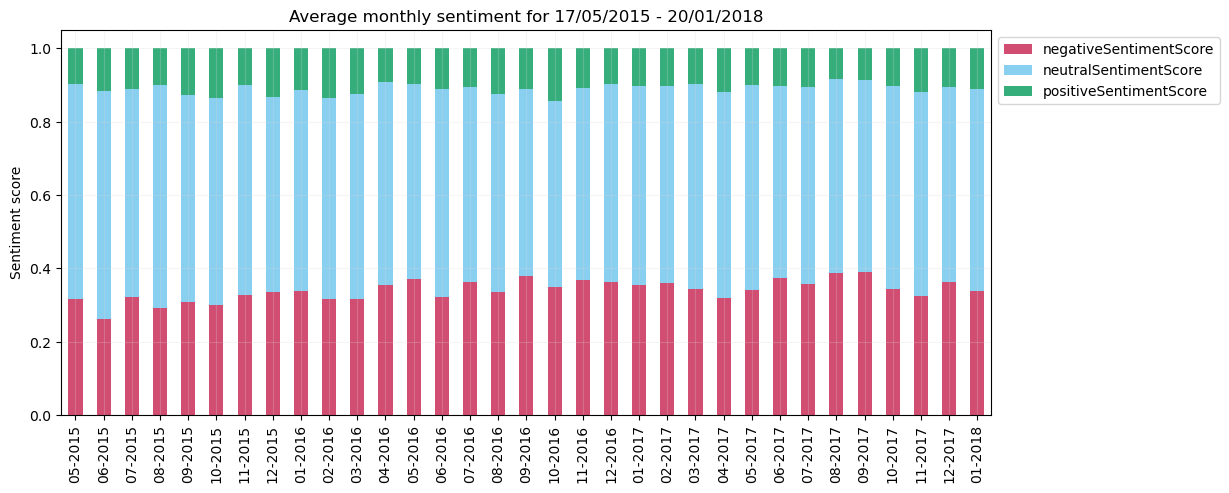

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_68066/2279777365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['tweet_month_year'].dt.strftime("%m-%Y")


<Figure size 1000x500 with 0 Axes>

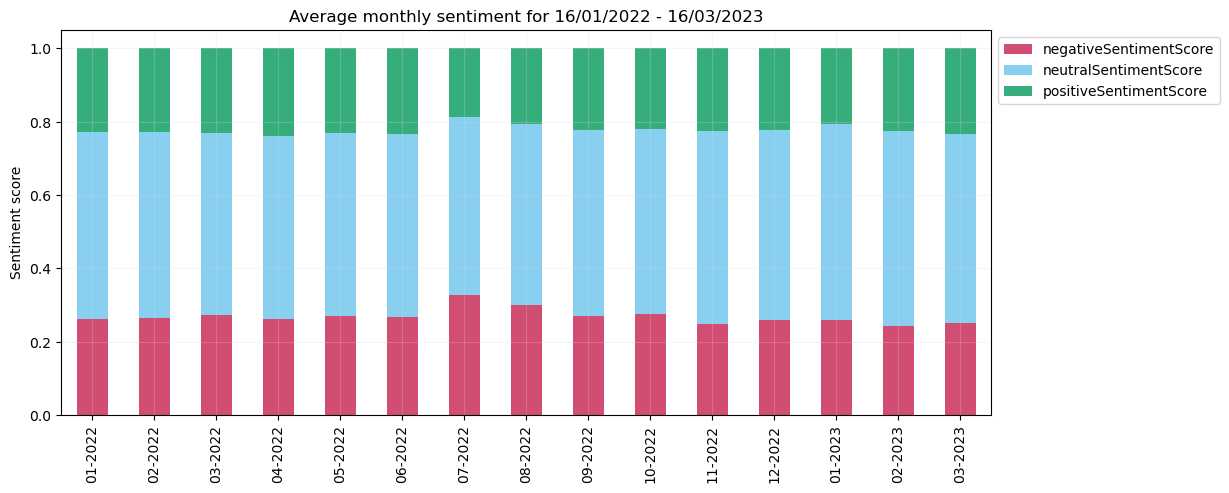

In [18]:
getTimeseriesSentimentBarGraph(old_df_monthly[(old_df_monthly['tweet_ts'] >= '2015-05-01') & (old_df_monthly['tweet_ts'] <= '2018-01-31')])
getTimeseriesSentimentBarGraph(new_df_monthly[(new_df_monthly['tweet_ts'] >= '2022-01-01') & (new_df_monthly['tweet_ts'] <= '2023-03-31')])

New DS limits:  2015-05-17 11:22:49.014084608


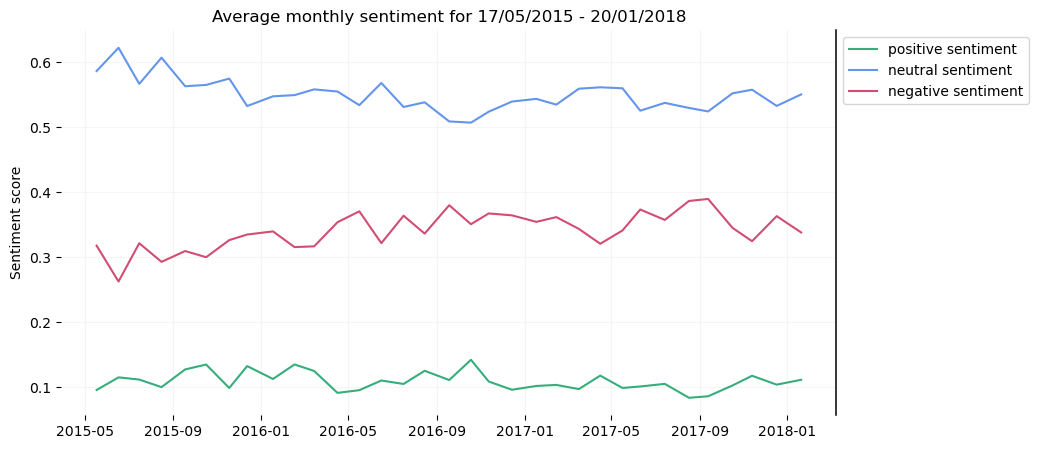

New DS limits:  2022-01-16 04:28:35.319662080


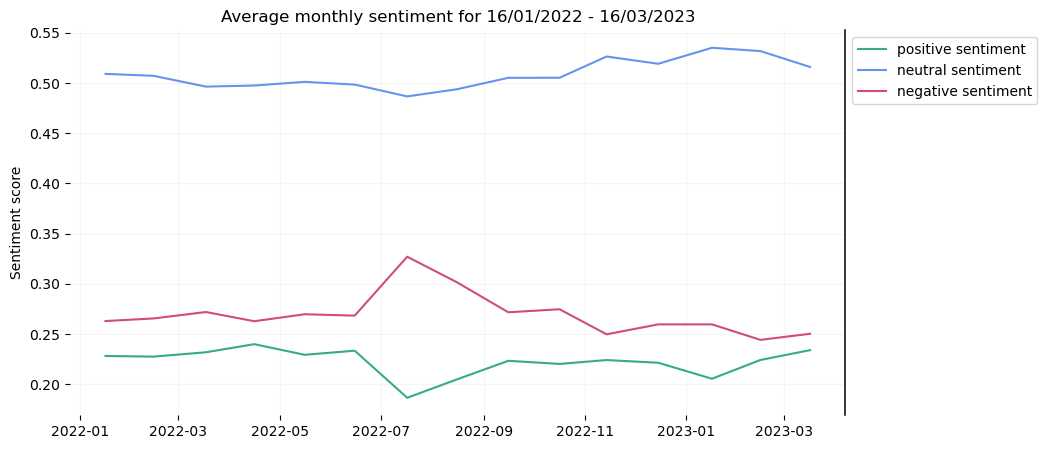

In [68]:
getTimeseriesSentimentGraph(old_df_monthly[(old_df_monthly['tweet_ts'] >= '2015-05-01') & (old_df_monthly['tweet_ts'] <= '2018-01-31')])
getTimeseriesSentimentGraph(new_df_monthly[(new_df_monthly['tweet_ts'] >= '2022-01-01') & (new_df_monthly['tweet_ts'] <= '2023-03-31')])

In [20]:
new_df_daily_count = new_df.groupby("tweet_ts").count().reset_index()
new_df_daily_count = new_df_daily_count[["tweet_ts", "tweet"]]
new_df_daily_count = new_df_daily_count.rename(columns={"tweet": "tweets"})
new_df_daily_count["tweet_ts"] = pd.to_datetime(new_df_daily_count['tweet_ts'], format='%d-%m-%Y')
new_df_daily_count = new_df_daily_count.sort_values(by=['tweet_ts'])

old_df_daily_count = old_df.groupby("tweet_ts").count().reset_index()
old_df_daily_count = old_df_daily_count[["tweet_ts", "tweet"]]
old_df_daily_count = old_df_daily_count.rename(columns={"tweet": "tweets"})
old_df_daily_count["tweet_ts"] = pd.to_datetime(old_df_daily_count['tweet_ts'], format='%d-%m-%Y')
old_df_daily_count = old_df_daily_count.sort_values(by=['tweet_ts'])



In [21]:
new_df_daily_count_max = new_df_daily_count.loc[new_df_daily_count['tweets'].idxmax()]
new_df_daily_count_max

tweet_ts    2022-04-22 00:00:00
tweets                     8521
Name: 112, dtype: object

In [22]:
df_daily_2023 = new_df_daily_count[
        (new_df_daily_count['tweet_ts'] >= '2022-07-20') & (new_df_daily_count['tweet_ts'] <= '2022-07-30') \
    ].sort_values('tweets', ascending=False)

df_daily_2023

,tweet_ts,tweets
201,2022-07-20,6955
202,2022-07-21,6134
209,2022-07-28,5361
206,2022-07-25,5349
207,2022-07-26,5217
210,2022-07-29,5175
208,2022-07-27,4832
203,2022-07-22,4742
204,2022-07-23,3760
205,2022-07-24,3718


In [23]:
def plotCalendar(datafr, valueKey='tweets', colorscale='YlGnBu'):
    events = pd.Series(datafr[valueKey].to_list(), index=datafr['tweet_ts'].to_list())

    fig,ax = calmap.calendarplot(events, fillcolor='lightgray', cmap=colorscale)
    fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())
    fig.set_size_inches(14.5, 8.5)



/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]
/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]
/Users/yaryn

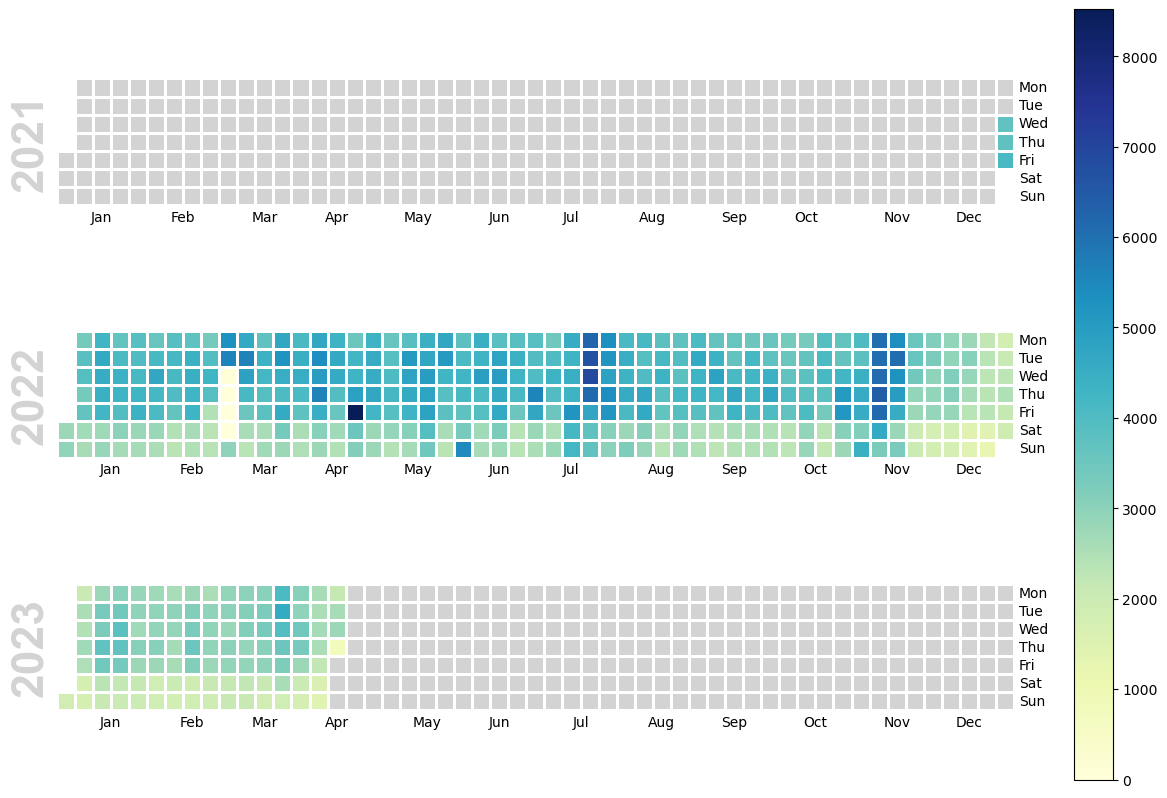

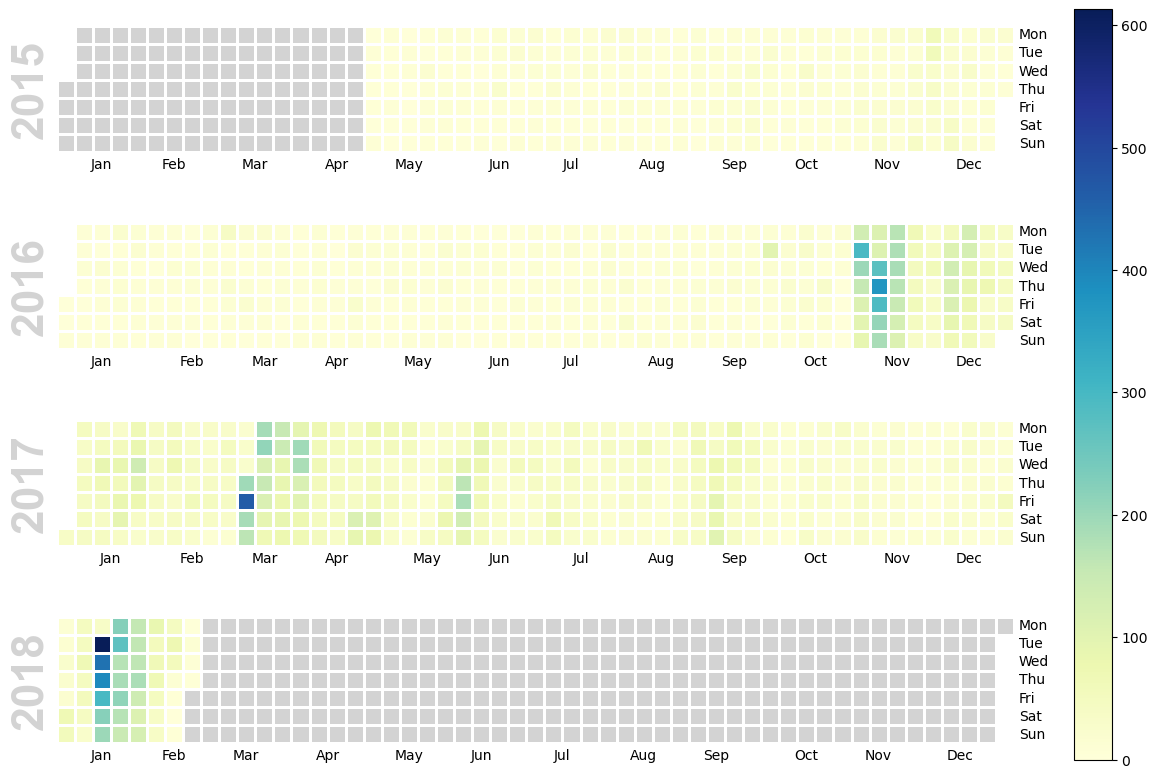

In [24]:
plotCalendar(new_df_daily_count)
plotCalendar(old_df_daily_count)


### Negative scale calender

In [25]:
new_df_daily_abs_negativity = new_df.groupby("tweet_ts").sum('negativeSentimentScore').reset_index()
new_df_daily_abs_negativity = new_df_daily_abs_negativity[["tweet_ts", "negativeSentimentScore"]]
new_df_daily_abs_negativity = new_df_daily_abs_negativity.rename(columns={"negativeSentimentScore": "absNegativeSentimentScore"})
new_df_daily_abs_negativity["tweet_ts"] = pd.to_datetime(new_df_daily_abs_negativity['tweet_ts'], format='%d-%m-%Y')
new_df_daily_abs_negativity = new_df_daily_abs_negativity.sort_values(by=['tweet_ts'])

old_df_daily_abs_negativity = old_df.groupby("tweet_ts").sum('negativeSentimentScore').reset_index()
old_df_daily_abs_negativity = old_df_daily_abs_negativity[["tweet_ts", "negativeSentimentScore"]]
old_df_daily_abs_negativity = old_df_daily_abs_negativity.rename(columns={"negativeSentimentScore": "absNegativeSentimentScore"})
old_df_daily_abs_negativity["tweet_ts"] = pd.to_datetime(old_df_daily_abs_negativity['tweet_ts'], format='%d-%m-%Y')
old_df_daily_abs_negativity = old_df_daily_abs_negativity.sort_values(by=['tweet_ts'])

new_df_daily_abs_positivity = new_df.groupby("tweet_ts").sum('positiveSentimentScore').reset_index()
new_df_daily_abs_positivity = new_df_daily_abs_positivity[["tweet_ts", "positiveSentimentScore"]]
new_df_daily_abs_positivity = new_df_daily_abs_positivity.rename(columns={"positiveSentimentScore": "absPositiveSentimentScore"})
new_df_daily_abs_positivity["tweet_ts"] = pd.to_datetime(new_df_daily_abs_positivity['tweet_ts'], format='%d-%m-%Y')
new_df_daily_abs_positivity = new_df_daily_abs_positivity.sort_values(by=['tweet_ts'])

old_df_daily_abs_positivity = old_df.groupby("tweet_ts").sum('positiveSentimentScore').reset_index()
old_df_daily_abs_positivity = old_df_daily_abs_positivity[["tweet_ts", "positiveSentimentScore"]]
old_df_daily_abs_positivity = old_df_daily_abs_positivity.rename(columns={"positiveSentimentScore": "absPositiveSentimentScore"})
old_df_daily_abs_positivity["tweet_ts"] = pd.to_datetime(old_df_daily_abs_positivity['tweet_ts'], format='%d-%m-%Y')
old_df_daily_abs_positivity = old_df_daily_abs_positivity.sort_values(by=['tweet_ts'])

In [61]:
new_df_daily_abs_positivity .sort_values('absPositiveSentimentScore', ascending=False)
# [
        # (new_df_daily_abs_negativity['tweet_ts'] >= '2022-07-10') & (new_df_daily_abs_negativity['tweet_ts'] <= '2022-07-30') \
    # ]


,tweet_ts,absPositiveSentimentScore
112,2022-04-22,3464.872314
156,2022-06-05,1961.488159
67,2022-03-08,1658.997070
314,2022-11-10,1585.983032
313,2022-11-09,1422.636475
...,...,...
358,2022-12-24,272.442688
359,2022-12-25,257.893250
468,2023-04-13,178.021851
63,2022-03-02,19.278969


In [116]:
old_df_daily_abs_positivity .sort_values('absPositiveSentimentScore', ascending=False)


,tweet_ts,absPositiveSentimentScore
989,2018-01-16,70.415863
991,2018-01-18,44.610817
990,2018-01-17,43.292053
548,2016-11-01,40.903637
677,2017-03-10,38.667828
...,...,...
281,2016-02-03,0.060563
17,2015-05-15,0.042739
459,2016-07-31,0.040977
349,2016-04-12,0.036580


In [106]:
new_df_daily_abs_negativity.sort_values('absNegativeSentimentScore', ascending=False).head(30)


,tweet_ts,absNegativeSentimentScore
201,2022-07-20,2470.008057
200,2022-07-19,2403.748291
199,2022-07-18,2196.579102
202,2022-07-21,2061.927002
181,2022-06-30,1991.858032
196,2022-07-15,1877.842651
61,2022-02-28,1788.079712
62,2022-03-01,1781.385010
206,2022-07-25,1730.060791
197,2022-07-16,1643.357544


/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]
/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/calmap/__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]
/Users/yaryn

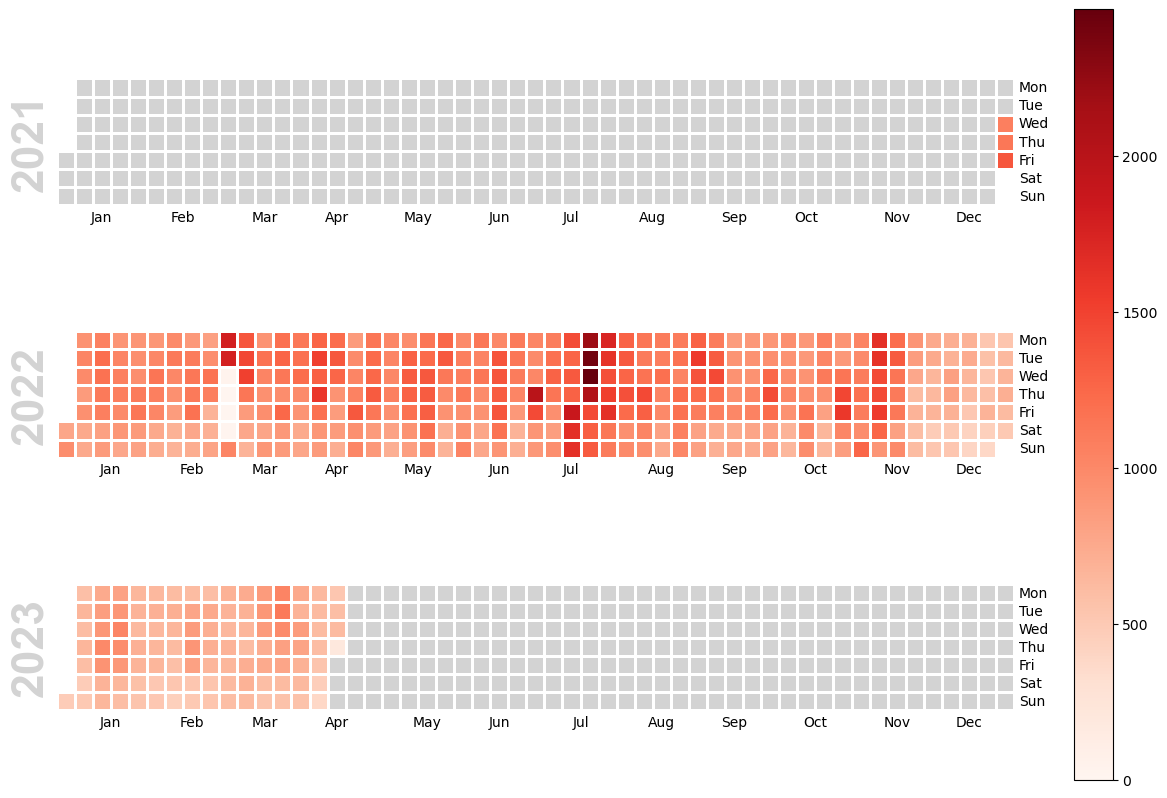

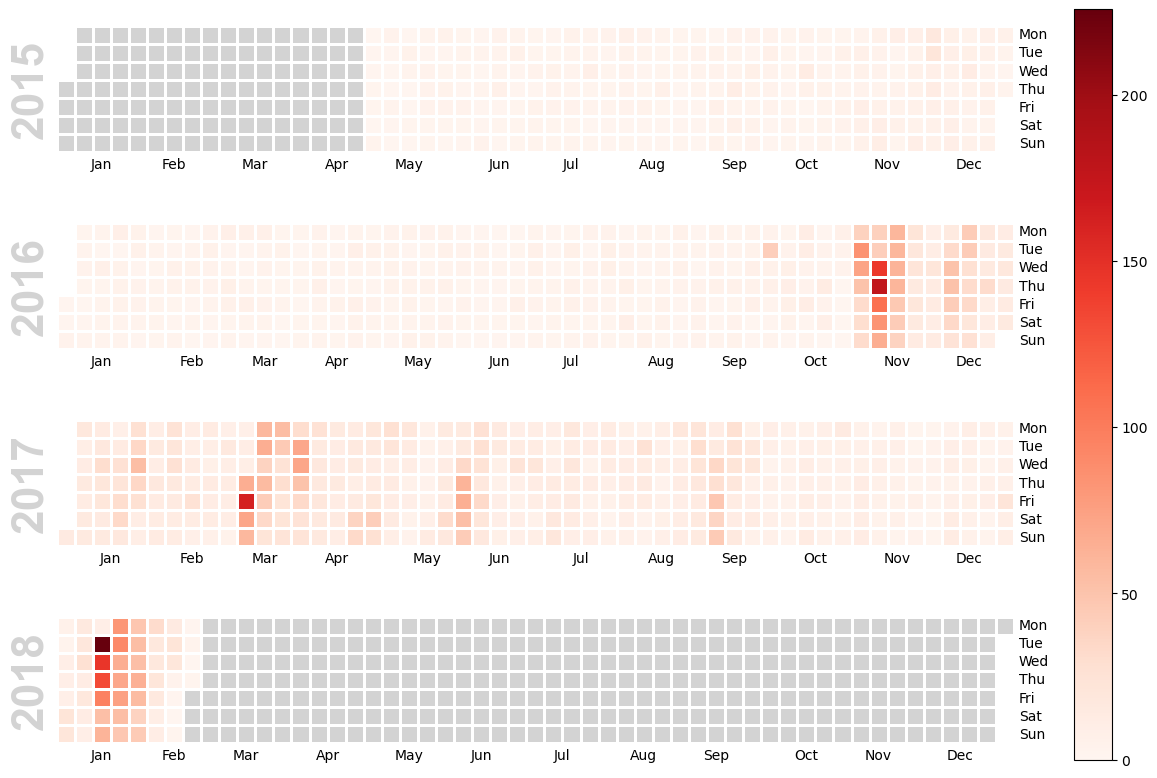

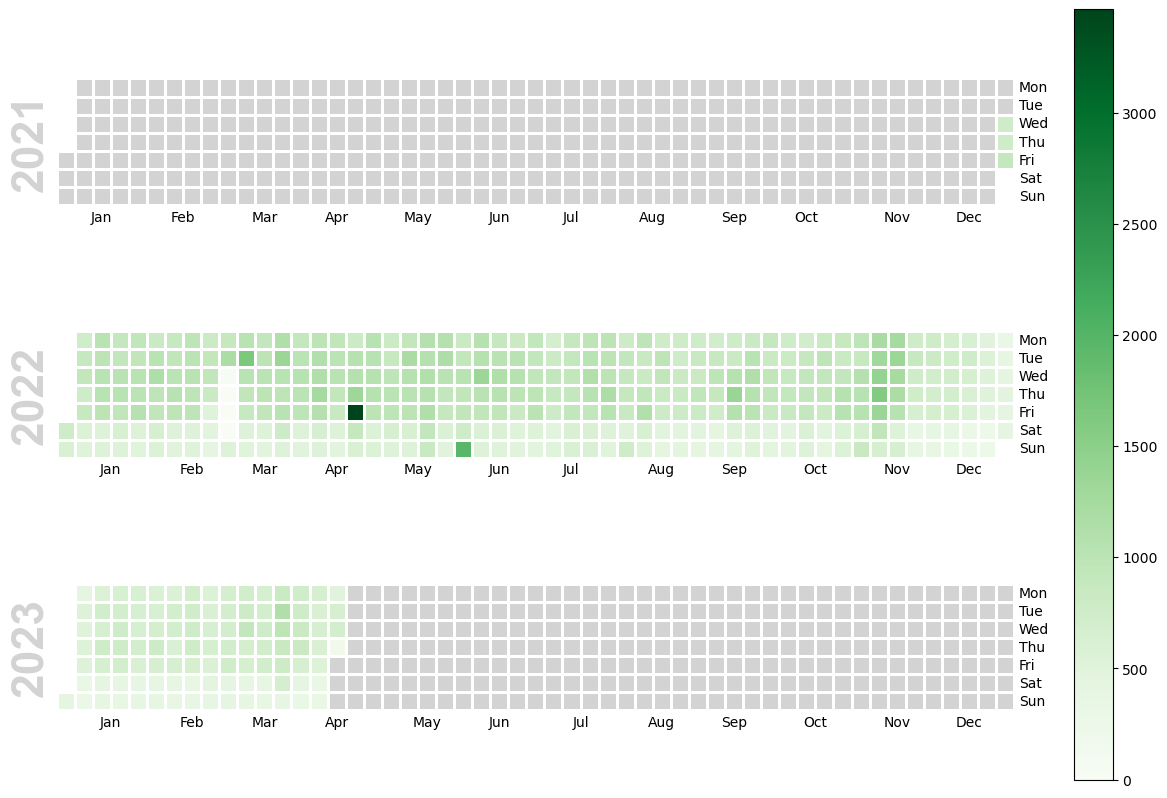

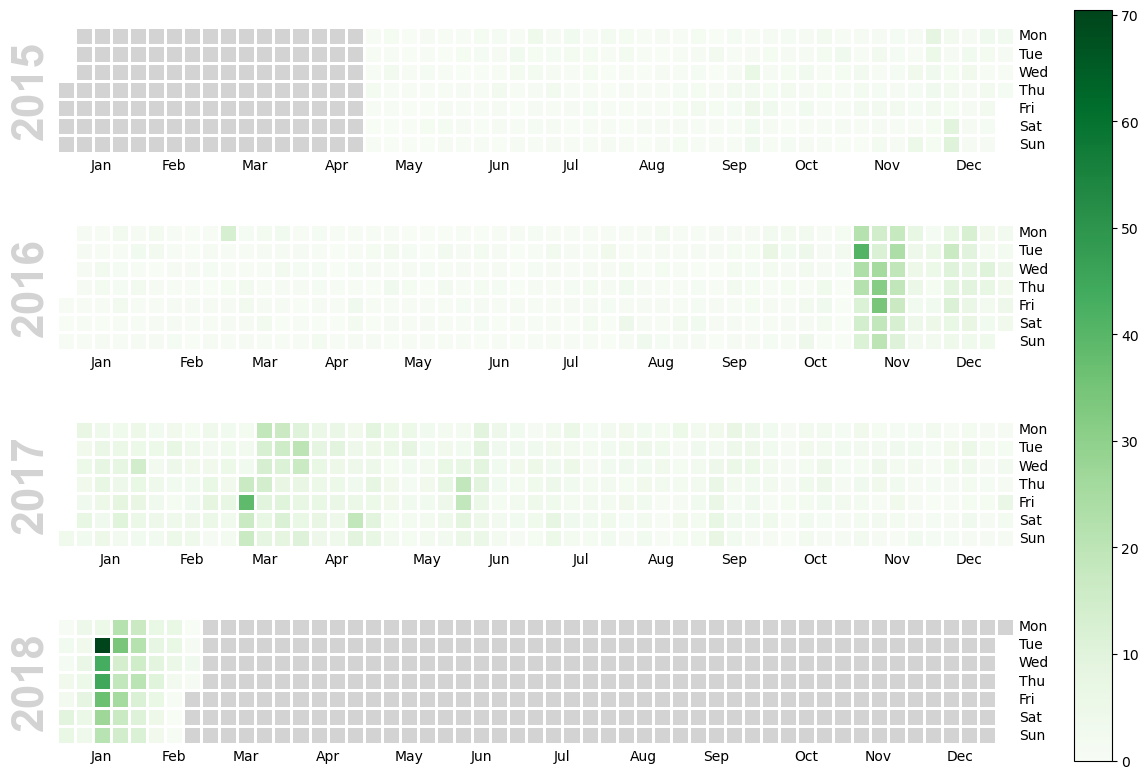

In [27]:
plotCalendar(new_df_daily_abs_negativity, 'absNegativeSentimentScore', colorscale="Reds")
plotCalendar(old_df_daily_abs_negativity, 'absNegativeSentimentScore', colorscale="Reds")

plotCalendar(new_df_daily_abs_positivity, 'absPositiveSentimentScore', colorscale="Greens")
plotCalendar(old_df_daily_abs_positivity, 'absPositiveSentimentScore', colorscale="Greens")

In [108]:
# positive
df_tweets_22_04_22 = new_df[(new_df['tweet_ts'] == '2022-04-22')]
# positive
df_tweets_05_06_22 = new_df[(new_df['tweet_ts'] == '2022-06-05')]
# negative
df_tweets_1521_07_22 = new_df[(new_df['tweet_ts'] >= '2022-07-15') & (new_df['tweet_ts'] <= '2022-07-21')]
# negative
df_tweets_2530_07_22 = new_df[(new_df['tweet_ts'] >= '2022-07-25') & (new_df['tweet_ts'] <= '2022-07-30')]
# negative
df_tweets_30_06_22 = new_df[(new_df['tweet_ts'] == '2022-06-30')]
# negative
df_tweets_2802_0103_22 = new_df[(new_df['tweet_ts'] >= '2022-02-28') & (new_df['tweet_ts'] <= '2022-03-01')]

In [124]:
def buildWordCloud(datafrForCloud, column='tweet', indicator='negativeSentimentScore', shouldFilter=True):

    if (shouldFilter == True):
        datafr = datafrForCloud.sort_values(indicator, ascending=False) \
            .head(round(datafrForCloud.shape[0] * 0.25))
    else:
        datafr = datafrForCloud
    
    texts = datafr[column].to_list()
    texts_str = ' '.join(texts)

    stop = STOPWORDS.update(['climate', 'climatechange', 'climatecrisis', 'climateaction', 'climateemergency', 'climateactionnow'])
    wordcloud = WordCloud(
        max_font_size=85, max_words=60, background_color="white", stopwords=stop,
        width=600, height=300
    ).generate(texts_str)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


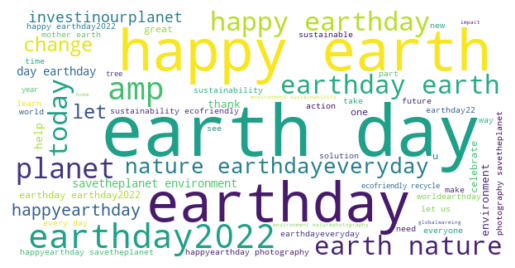

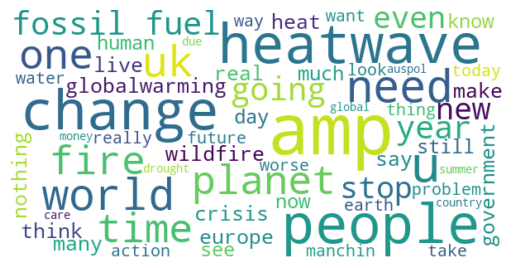

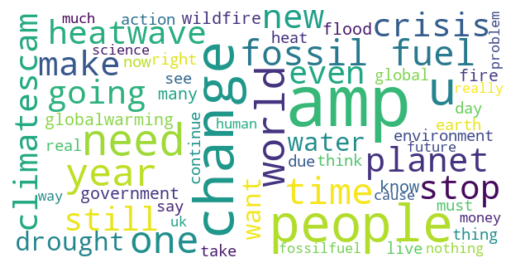

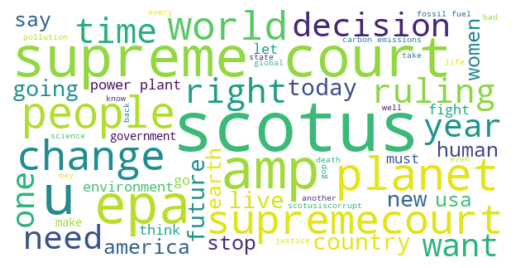

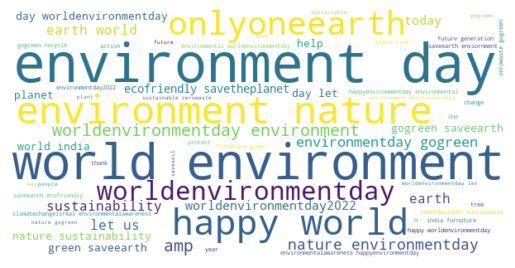

In [104]:
buildWordCloud(df_tweets_22_04_22, indicator='positiveSentimentScore')
buildWordCloud(df_tweets_1521_07_22)
buildWordCloud(df_tweets_2530_07_22)
buildWordCloud(df_tweets_30_06_22)
buildWordCloud(df_tweets_05_06_22, indicator='positiveSentimentScore')

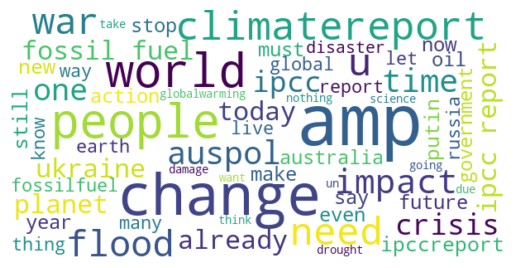

In [109]:
buildWordCloud(df_tweets_2802_0103_22)

In [115]:
df_tweets_2802_0103_22[df_tweets_2802_0103_22["tweet"].str.contains('ukraine') & df_tweets_2802_0103_22["tweet"].str.contains('nuclear')].head(30)

,tweet,tweet_ts,hashtags,sentimentScore,negativeSentimentScore,neutralSentimentScore,positiveSentimentScore,tweet_month_year
167195,"much #ukrainerussiawar #nuclearwar threat #climatereport #climatecrisis #biodiversitycrisis #extinction &amp; #plasticpollution crises overwhelmed &amp; trying hard. keep simple. bring love all, including myself. let go &amp; let god.",2022-02-28,"[#ukrainerussiawar, #nuclearwar, #climatereport, #climatecrisis, #biodiversitycrisis, #extinction, #plasticpollution]","[0.44953087, 0.46263275, 0.08783635]",0.449531,0.462633,0.087836,2022-02-01
244626,"worried putins nuclear saber rattling? might better use worry worry climate change, think? #climatechange #climatereport #ukraine",2022-02-28,"[#climatechange, #climatereport, #ukraine]","[0.69320214, 0.29069725, 0.016100688]",0.693202,0.290697,0.016101,2022-02-01
251957,oh cool #abc throwing #solarstorms #catastrophiesmix #ipcc #climatechange #floods #heatrecords #ukraine #nuclearthreat #mice #asteroids #economiccollapse etc etc 2022,2022-03-01,"[#abc, #solarstorms, #catastrophiesmix, #ipcc, #climatechange, #floods, #heatrecords, #ukraine, #nuclearthreat, #mice, #asteroids, #economiccollapse]","[0.031105815, 0.54747695, 0.4214172]",0.031106,0.547477,0.421417,2022-03-01
344047,"let's it. time #nuclearwar #climatechange #globalwarming!! #gretathunberg get board!! hell al gore? ""what want?"" ""nuclear war!!"" ""when want it?"" ""now!!!!"" #ukraine #russia",2022-02-28,"[#nuclearwar, #climatechange, #globalwarming, #gretathunberg, #ukraine, #russia]","[0.519069, 0.37714237, 0.10378865]",0.519069,0.377142,0.103789,2022-02-01
369352,"threat #nukes terrifying nuclear weapons powerful. yet, climate change alarmists leftist governments admit best source of..power. #russiaukrainewar #climateaction #nuclearwar",2022-02-28,"[#nukes, #russiaukrainewar, #climateaction, #nuclearwar]","[0.5147675, 0.4297618, 0.055470623]",0.514768,0.429762,0.055471,2022-02-01
545309,"latest report warns ""irreversible impacts global warming"". impacts possible third world war climate targets? #climatereport #climatechange even nuclear attacks destroy planet? #ukrainerussia",2022-02-28,"[#climatereport, #climatechange, #ukrainerussia]","[0.80869883, 0.18391319, 0.0073879403]",0.808699,0.183913,0.007388,2022-02-01
576429,"know there's thing happening, take time doomscrolling re: #ukraine listen #ipcc telling us #climatecrisis certain outcome nuclear armageddon.",2022-02-28,"[#ukraine, #ipcc, #climatecrisis]","[0.26856017, 0.68765664, 0.04378323]",0.268560,0.687657,0.043783,2022-02-01
622385,"report need talking finding solutions save climate. instead, putin, overwhelmed work worry war #ukraine threat #worldwariii. so. unnecessary. #nuclearban #climateaction",2022-03-01,"[#ukraine, #worldwariii, #nuclearban, #climateaction]","[0.85038143, 0.14027011, 0.009348403]",0.850381,0.140270,0.009348,2022-03-01
644119,today: putin's war tanking? #ukrainewar #putin #russia #kiev #zelensky #ukraine #switzerland #rouble #ruble #economy #israel #germany #belarus #nuclearwar #biden #sotu #cpac #trump #fgm #mexico #ipcc #climatecrisis #plastic #sagawards #joerogan #media,2022-02-28,"[#ukrainewar, #putin, #russia, #kiev, #zelensky, #ukraine, #switzerland, #rouble, #ruble, #economy, #israel, #germany, #belarus, #nuclearwar, #biden, #sotu, #cpac, #trump, #fgm, #mexico, #ipcc, #climatecrisis, #plastic, #sagawards, #joerogan, #media]","[0.40479115, 0.5805263, 0.014682634]",0.404791,0.580526,0.014683,2022-02-01
692378,"definition cannot progressive (or isolationist), war hawk advocating hot war #russia &amp; #natoinukrainenow. &amp; nuclear winter answer #climatecrisis - duh! #ukraine much complex media reports - compromise needed",2022-03-01,"[#russia, #natoinukrainenow, #climatecrisis, #ukraine]","[0.7643194, 0.2241763, 0.011504285]",0.764319,0.224176,0.011504,2022-03-01


### Old data analysis

In [117]:
old_df_daily_abs_negativity.sort_values('absNegativeSentimentScore', ascending=False).head(30)

,tweet_ts,absNegativeSentimentScore
989,2018-01-16,225.865906
557,2016-11-10,176.464630
677,2017-03-10,161.773010
990,2018-01-17,146.284851
556,2016-11-09,143.136108
991,2018-01-18,132.131287
558,2016-11-11,109.336205
992,2018-01-19,96.471207
996,2018-01-23,91.387573
548,2016-11-01,84.201096


In [133]:
df_tweets_1619_01_18 = old_df[(old_df['tweet_ts'] >= '2018-01-16') & (old_df['tweet_ts'] <= '2018-01-19')]

df_tweets_0913_11_16 = old_df[(old_df['tweet_ts'] >= '2016-11-09') & (old_df['tweet_ts'] <= '2016-11-13')]

df_tweets_0912_03_17 = old_df[(old_df['tweet_ts'] >= '2017-03-09') & (old_df['tweet_ts'] <= '2017-03-12')]


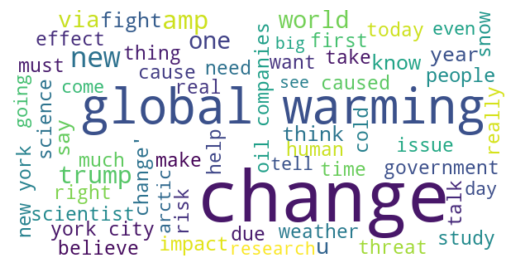

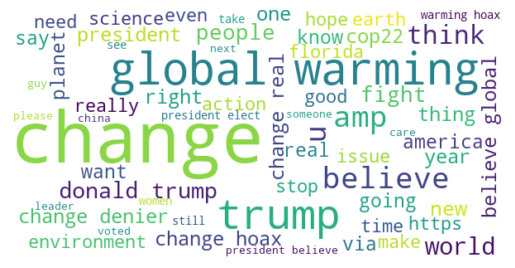

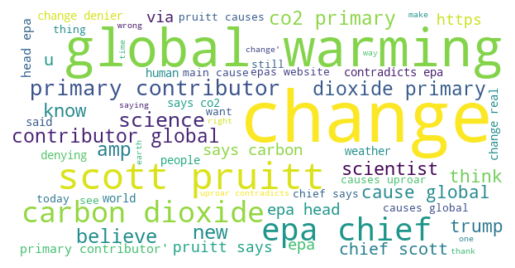

In [134]:

buildWordCloud(df_tweets_1619_01_18, shouldFilter=False)

buildWordCloud(df_tweets_0913_11_16, shouldFilter=False)

buildWordCloud(df_tweets_0912_03_17, shouldFilter=False)


### Positive
1. 22 April 2022 - Earth Day 2022
2. 05 June 2022 - World Environment Day 2022

### Negative
1. July 2022 - Heatwave
2. End of July 2022 - Heatwave, Kentucky Flooding; Climatescam (?) https://foe.org/news/cop-27-disinfo-report/; https://jembendell.com/2022/11/09/when-climatescam-is-trending-rethinking-climate-comms/; 
3. 30 June 2022 - Supreme Court restricts the EPA's authority to mandate carbon emissions reductions
4. 28 February - 1 March - Lismore Flood (https://www.theguardian.com/australia-news/2022/feb/28/lismore-flood-worst-history-nsw-floods-2022-rescued-evacuated), War in Ukraine, humanitarian crisis, possible nuclear war

### Observations
1. There are in general more tweets on the workdays
2. Most of the word clouds, even for positive effects, contain the slang abbreviarion 'amp'